# Demo 1 - Comparing BCI pipelines with MOABB - Code based on this [tutorial](http://moabb.neurotechx.com/docs/auto_examples/advanced_examples/plot_statistical_analysis.html#sphx-glr-download-auto-examples-advanced-examples-plot-statistical-analysis-py) 

In [2]:
import matplotlib.pyplot as plt
from mne.decoding import CSP
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

import moabb
from moabb import benchmark, set_log_level
from moabb.analysis.plotting import score_plot
import moabb.analysis.plotting as moabb_plt
from moabb.analysis.meta_analysis import (  # noqa: E501
    compute_dataset_statistics,
    find_significant_differences,
)
from moabb.datasets import BNCI2014_001, Zhou2016, Cho2017
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery

import seaborn as sns

moabb.set_log_level("info")
print(__doc__)


Automatically created module for IPython interactive environment


In [10]:
# pipelines to be compared

pipelines = {}

param_svm = {"kernel": ("linear", "rbf"), "C": [0.1, 1, 10]}
step_csp_svm = [
    ("cov", Covariances(estimator="lwf")),
    ("csp", CSP(6)),
    ("optsvm", GridSearchCV(SVC(), param_svm, cv=3)),
]
pipelines["CSP+optSVM"] = Pipeline(steps=step_csp_svm)


step_csp_lda=[("csp", CSP(8)), ("LDA", LDA())]
pipelines["CSP+LDA"] = Pipeline(steps=step_csp_lda)

step_rg_lr =[ ("cov", Covariances()), ("RG", TangentSpace()), ("LR", LogisticRegression())]
pipelines["RG+LR"] = Pipeline(steps=step_rg_lr)

step_csp_lr =[("csp", CSP(8)), ("LR", LogisticRegression())]
pipelines["CSP+LR"] = Pipeline(steps=step_csp_lr)

step_rg_lda =[("cov", Covariances()), ("RG", TangentSpace()), ("LDA", LogisticRegression())]
pipelines["RG+LDA"] = Pipeline(steps=step_rg_lda)


In [13]:
# evaluation on one dataset

paradigm = LeftRightImagery()
dataset = BNCI2014_001()
dataset.subject_list = dataset.subject_list[:4]
datasets = [dataset]
overwrite = True  # set to False if we want to use cached results
evaluation = CrossSessionEvaluation(
    paradigm=paradigm, datasets=datasets, suffix="stats", overwrite=overwrite
)

results = evaluation.process(pipelines)

2025-03-10 11:25:52,327 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|                                                                                                               | 0/4 [00:00<?, ?it/s]/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 6 s, baseline off, ~4.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 6 s, baseline off, ~4.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <E

2025-03-10 11:26:44,313 WARNING MainThread moabb.analysis.plotting Dataset names are too similar, turning off name shortening
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/analysis/plotting.py:70: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sea.stripplot(
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


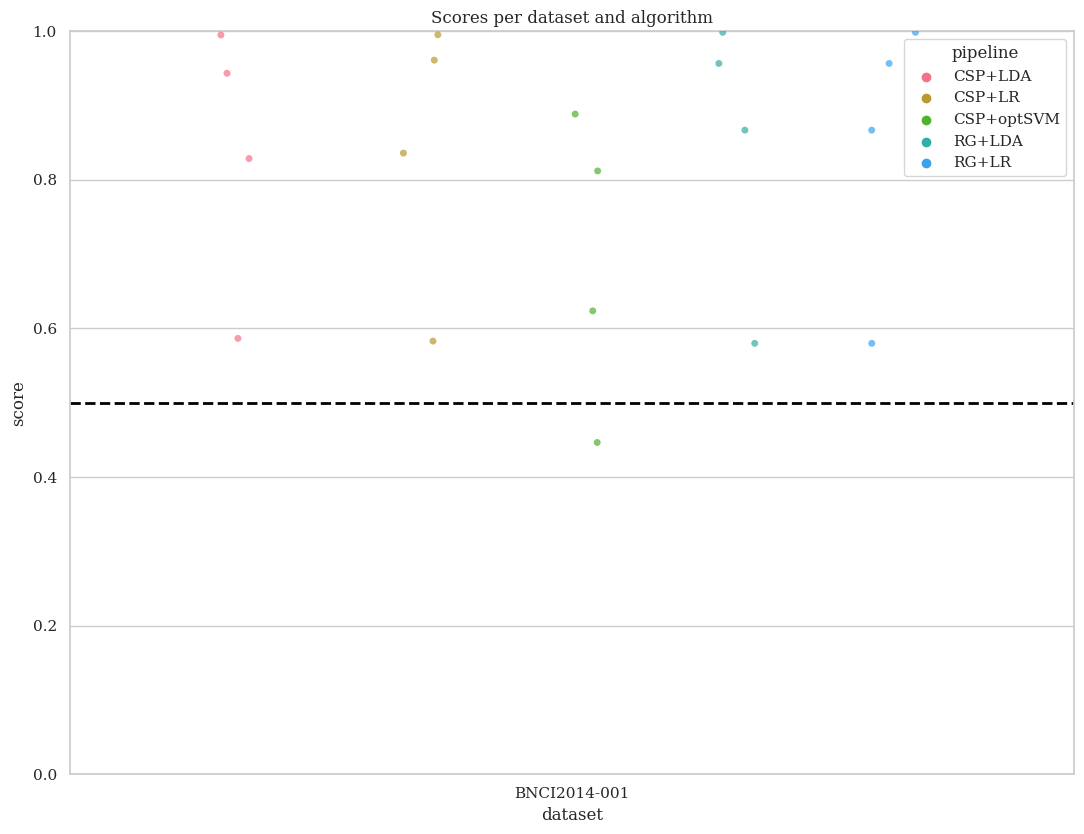

In [14]:
# plot comparison
fig = moabb_plt.score_plot(results)
plt.show()


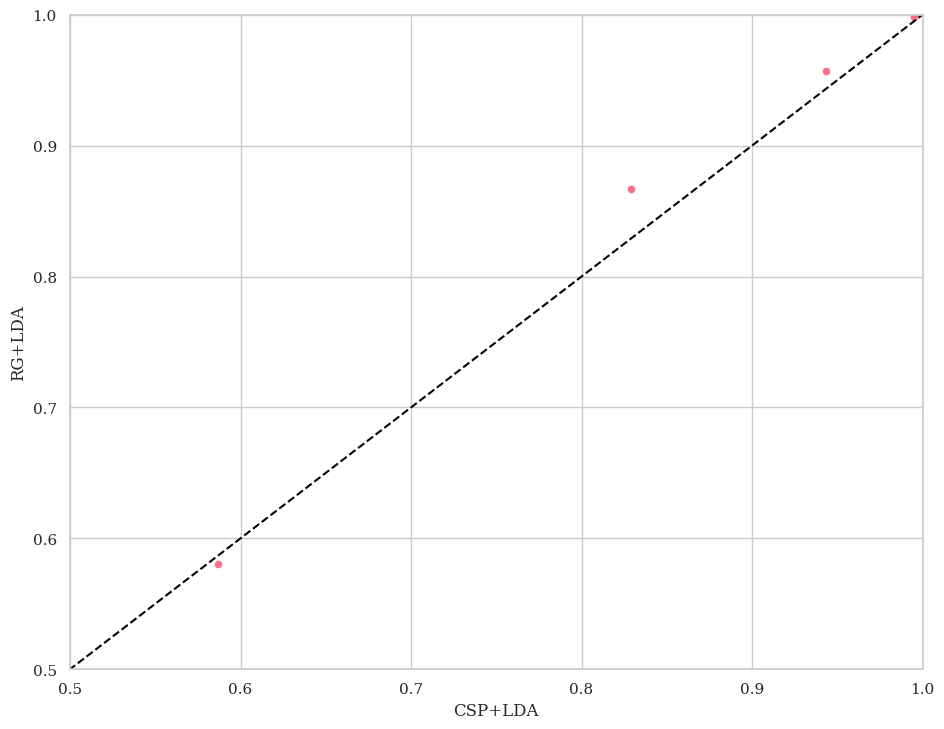

In [15]:
fig = moabb_plt.paired_plot(results, "CSP+LDA", "RG+LDA")
plt.show()



/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/analysis/meta_analysis.py:206: RuntimeWarning: invalid value encountered in scalar divide
  diffs = diffs.mean() / diffs.std()
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/analysis/plotting.py:298: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  nsub = float(df_fw.loc[df_fw.dataset == d, "nsub"])
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/analysis/plotting.py:301: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  v = float(df_fw.loc[df_fw.dataset == d, "smd"])


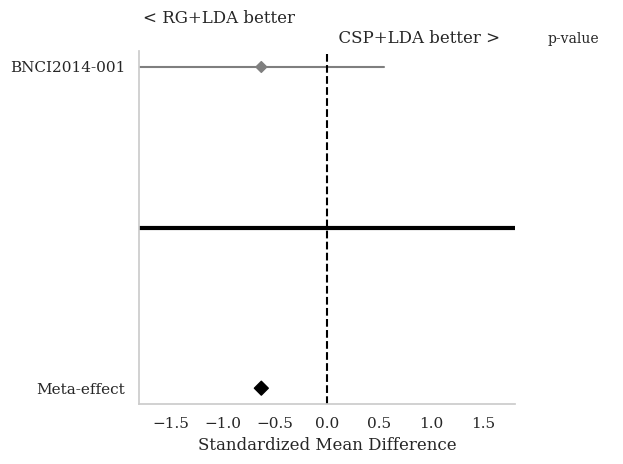

In [16]:
# plot statistical comparison
stats = compute_dataset_statistics(results)
P, T = find_significant_differences(stats)

fig = moabb_plt.meta_analysis_plot(stats, "CSP+LDA", "RG+LDA")
plt.show()

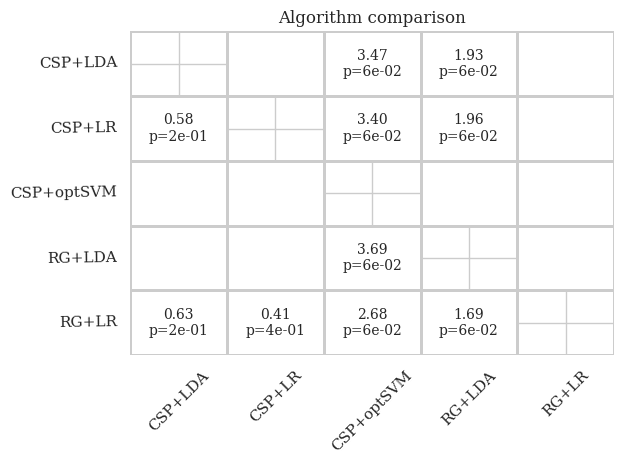

In [14]:
moabb_plt.summary_plot(P, T)
plt.show()

# Demo 2 - Benchmarking with different datasets

In [18]:
paradigm = LeftRightImagery()
subj = [1, 2, 3]
datasets = [BNCI2014_001(), Zhou2016()]
for d in datasets:
    d.subject_list = subj

overwrite = True  # set to False if we want to use cached results
evaluation = CrossSessionEvaluation(
    paradigm=paradigm, datasets=datasets, suffix="stats", overwrite=overwrite
)

results = evaluation.process(pipelines)

2025-03-10 11:27:02,879 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|                                                                                                               | 0/3 [00:00<?, ?it/s]/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 6 s, baseline off, ~4.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 6 s, baseline off, ~4.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <E

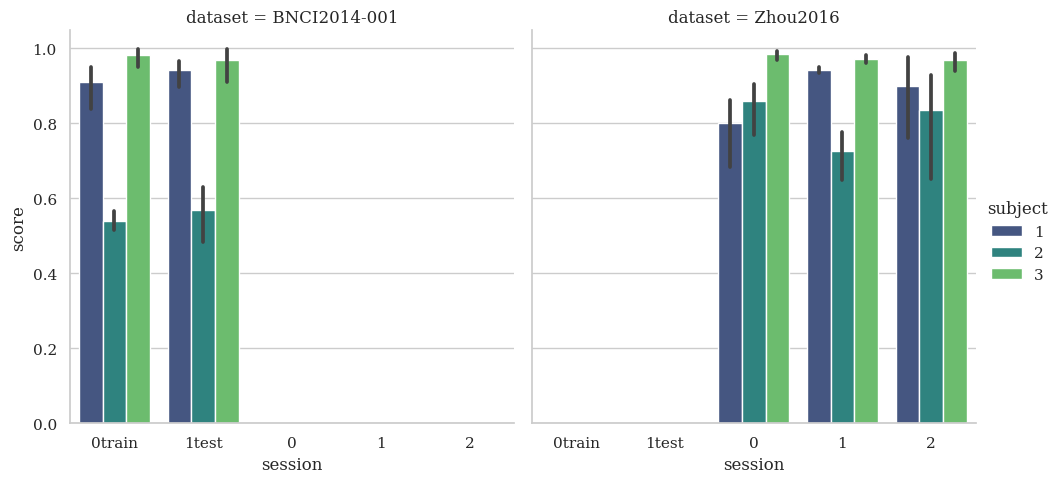

In [19]:

sns.catplot(
    data=results,
    x="session",
    y="score",
    hue="subject",
    col="dataset",
    kind="bar",
    palette="viridis",
)
plt.show()

2025-03-10 11:28:55,017 WARNING MainThread moabb.analysis.plotting Dataset names are too similar, turning off name shortening
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/analysis/plotting.py:70: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sea.stripplot(
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


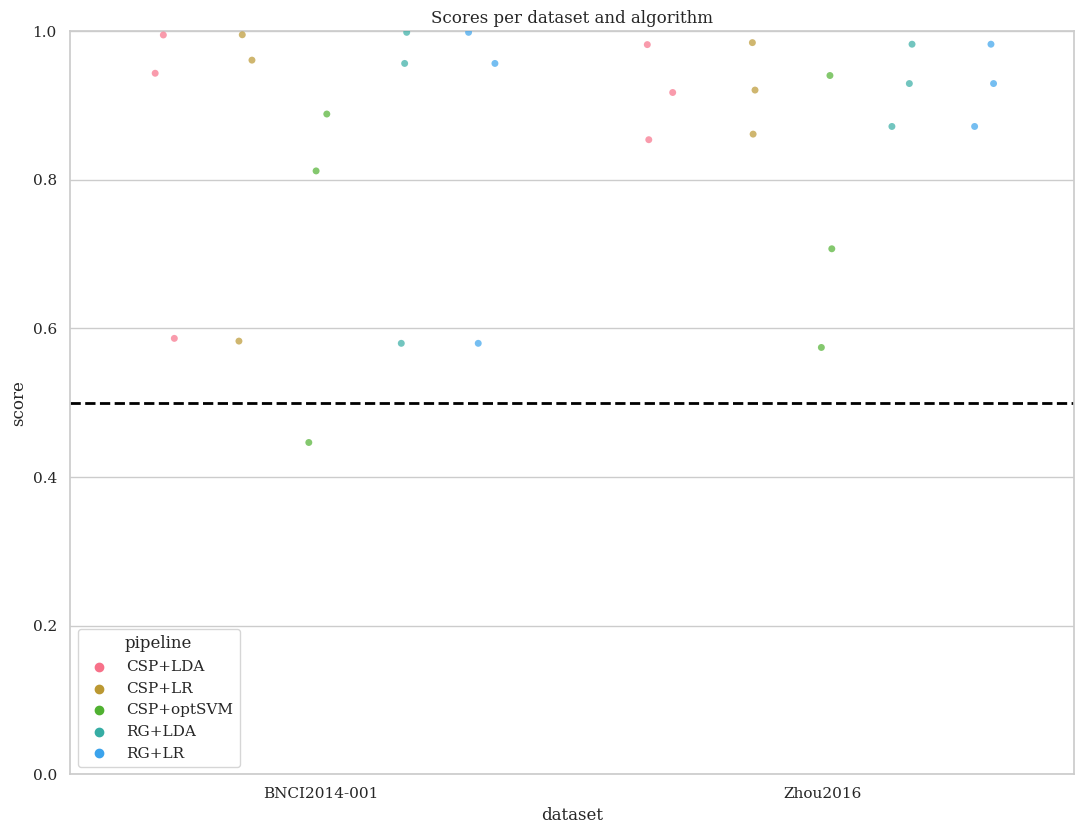

In [20]:
fig = moabb_plt.score_plot(results)
plt.show()

/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/analysis/meta_analysis.py:206: RuntimeWarning: invalid value encountered in scalar divide
  diffs = diffs.mean() / diffs.std()
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/analysis/meta_analysis.py:206: RuntimeWarning: invalid value encountered in scalar divide
  diffs = diffs.mean() / diffs.std()
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/analysis/plotting.py:212: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_df.loc[row, col] = txt
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/analysis/plotting.py:212: FutureWarning: Setting an item of incompatible dtype is deprecated 

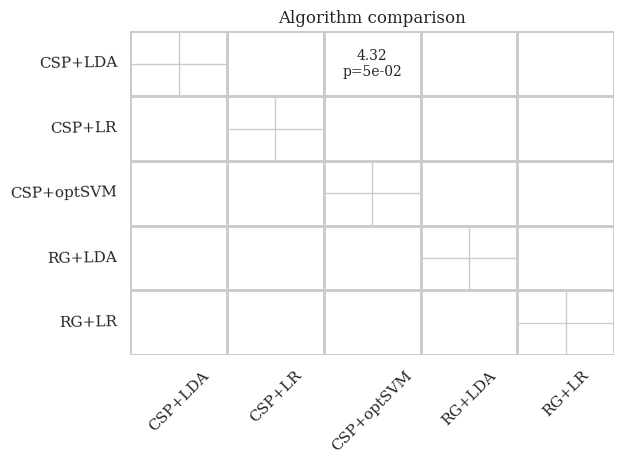

In [21]:
stats = compute_dataset_statistics(results)
P, T = find_significant_differences(stats)
moabb_plt.summary_plot(P, T)
plt.show()


/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/analysis/plotting.py:298: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  nsub = float(df_fw.loc[df_fw.dataset == d, "nsub"])
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/moabb/analysis/plotting.py:301: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  v = float(df_fw.loc[df_fw.dataset == d, "smd"])


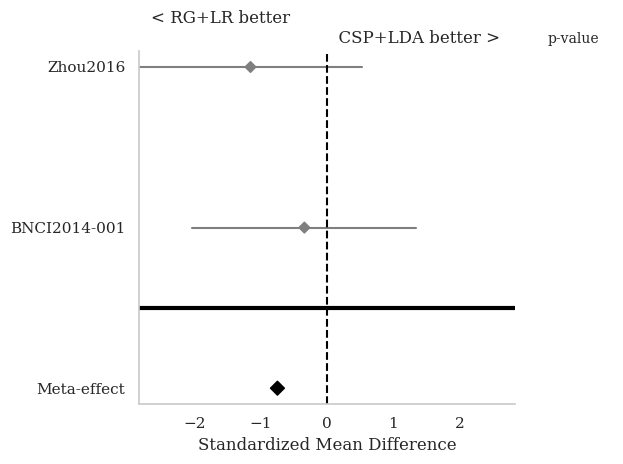

In [22]:
fig = moabb_plt.meta_analysis_plot(stats, "CSP+LDA", "RG+LR")
plt.show()

# Demo 3 - Use of alternative features based on functional connectivity - Code based on this [tutorial](https://pyriemann.readthedocs.io/en/latest/auto_examples/motor-imagery/plot_ensemble_coherence.html)

In [23]:
import matplotlib.pyplot as plt

from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci

import numpy as np
import pandas as pd
import seaborn as sns

from pyriemann.classification import FgMDM
from pyriemann.estimation import Covariances, Coherences
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


from helpers.coherence_helpers import (
    NearestSPD,
    get_results,
)

## Connectivity transformer to compute FC estimations

In [24]:
class Connectivities(TransformerMixin, BaseEstimator):
    """Getting connectivity features from epoch"""

    def __init__(self, method="ordinary", fmin=8, fmax=35, fs=None):
        self.method = method
        self.fmin = fmin
        self.fmax = fmax
        self.fs = fs

    def fit(self, X, y=None):
        self._coh = Coherences(
            coh=self.method,
            fmin=self.fmin,
            fmax=self.fmax,
            fs=self.fs,
        )
        return self

    def transform(self, X):
        X_coh = self._coh.fit_transform(X)
        X_con = np.mean(X_coh, axis=-1, keepdims=False)
        return X_con

## EEG data

In [25]:
# avoid classification of evoked responses by using epochs that start 1s after cue onset.
tmin, tmax = 1.0, 2.0
event_id = dict(hands=2, feet=3)
subject = 7
runs = [4, 8]  # motor imagery: left vs right hand

raw_files = [
    read_raw_edf(f, preload=True) for f in eegbci.load_data(subject, runs)
]
raw = concatenate_raws(raw_files)

picks = pick_types(
    raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads"
)
# subsample elecs
picks = picks[::2]

# Apply band-pass filter
raw.filter(7.0, 35.0, method="iir", picks=picks)

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

# Read epochs (train will be done only between 1 and 2s)
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
    verbose=False,
)
labels = epochs.events[:, -1] - 2
fs = epochs.info["sfreq"]
X = 1e6 * epochs.get_data()

/var/folders/d4/_4q888f9053cl142j5r3tmy00000gq/T/ipykernel_93330/3839924582.py:38: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = 1e6 * epochs.get_data()


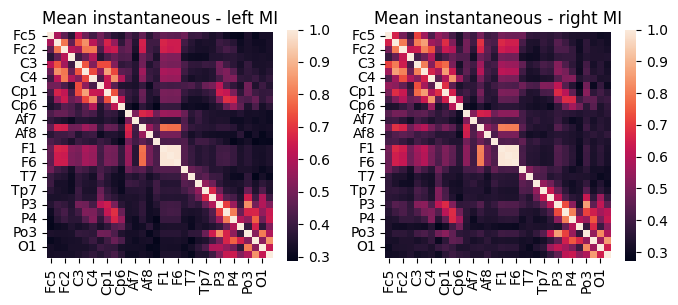

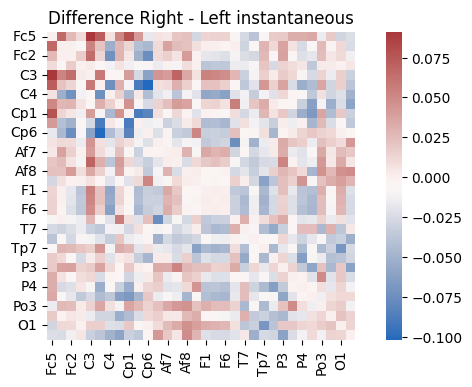

In [193]:
# plot infos features
idx_left=np.where(labels==0)
idx_right=np.where(labels==1)

X_left=np.squeeze(X[idx_left,:,:])
X_right=np.squeeze(X[idx_right,:,:])

mat_connect_left=dict()
mat_connect_right=dict()

param_ft = {"fmin": fmin, "fmax": fmax, "fs": fs}
for sm in spectral_met:
    if sm == "cov":
        Y=Covariances(estimator="lwf").transform(X)
        mat_connect_left[sm]=Y[idx_left,:,:]
        mat_connect_right[sm]=Y[idx_right,:,:]
    else:
        Y=Coherences(coh=sm, fmin=fmin, fmax=fmax, fs=fs).transform(X)
        avg_freqBand=Y.mean(axis=3)
        mat_connect_left[sm]=np.mean(np.squeeze(avg_freqBand[idx_left,:,:]),0) # direct averaged over the trials
        mat_connect_right[sm]=np.mean(np.squeeze(avg_freqBand[idx_right,:,:]),0)
        
        
# plot FC
sm=spectral_met[2]

fig, axes = plt.subplots(1,2, figsize=[8, 3])
ch_names = [ch.replace('.', '') for ch in epochs.ch_names]

df = pd.DataFrame(data=mat_connect_left[sm], index=ch_names, columns=ch_names)
g = sns.heatmap(
                df, ax=axes[0], square=True, cbar=True, xticklabels=2, yticklabels=2)
g.set_title('Mean ' + sm + ' - left MI')

df = pd.DataFrame(data=mat_connect_right[sm], index=ch_names, columns=ch_names)
g = sns.heatmap(
                df, ax=axes[1], square=True, cbar=True, xticklabels=2, yticklabels=2)
g.set_title('Mean ' + sm + ' - right MI')

plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
plt.show()


fig, axes = plt.subplots(figsize=[8, 4])
ch_names = [ch.replace('.', '') for ch in epochs.ch_names]

df = pd.DataFrame(data=mat_connect_right[sm]-mat_connect_left[sm], index=ch_names, columns=ch_names)
g = sns.heatmap(
                df, ax=axes, square=True, cbar=True, xticklabels=2, yticklabels=2, cmap="vlag")
g.set_title('Difference Right - Left ' + sm )

plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
plt.show()

## Pipelines definition

Here we are going to compare different methods: CSP+shLDA, CSP+SVM, FgMDM on covariance, tangent space logistic regression with covariance, lag coherence, and instantaneous coherence, along with ensemble method - *TODO: add more?*

In [26]:
ppl_baseline, ppl_fc, ppl_ens = {}, {}, {}

In [27]:
# Baseline pipelines
param_svm = {"kernel": ("linear", "rbf"), "C": [0.1, 1, 10]}
step_csp_svm = [
    ("cov", Covariances(estimator="lwf")),
    ("csp", CSP(nfilter=6)),
    ("optsvm", GridSearchCV(SVC(), param_svm, cv=3)),
]
ppl_baseline["CSP+optSVM"] = Pipeline(steps=step_csp_svm)


step_mdm = [
    ("cov", Covariances(estimator="lwf")),
    ("fgmdm", FgMDM(metric="riemann", tsupdate=False)),
]
ppl_baseline["FgMDM"] = Pipeline(steps=step_mdm)


In [28]:
# Functional connectivity pipelines
spectral_met = ["cov", "lagged", "instantaneous"]
fmin, fmax = 8, 35
param_lr = {
    "penalty": "elasticnet",
    "l1_ratio": 0.15,
    "intercept_scaling": 1000.0,
    "solver": "saga",
}
param_ft = {"fmin": fmin, "fmax": fmax, "fs": fs}
step_fc = [
    ("spd", NearestSPD()),
    ("tg", TangentSpace(metric="riemann")),
    ("LogistReg", LogisticRegression(**param_lr)),
]
for sm in spectral_met:
    pname = sm + "+elasticnet"
    if sm == "cov":
        ppl_fc[pname] = Pipeline(
            steps=[("cov", Covariances(estimator="lwf"))] + step_fc
        )
    else:
        ft = Connectivities(**param_ft, method=sm)
        ppl_fc[pname] = Pipeline(steps=[("ft", ft)] + step_fc)

In [29]:
# Ensemble classifier
fc_estim = [(n, ppl_fc[n]) for n in ppl_fc]
cvkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr = LogisticRegression(**param_lr)
ppl_ens["ensemble"] = StackingClassifier(
    estimators=fc_estim,
    cv=cvkf,
    n_jobs=1,
    final_estimator=lr,
    stack_method="predict_proba",
)

### Evaluation

In [30]:
dataset_res = list()
all_ppl = {**ppl_baseline, **ppl_ens}
#print(all_ppl)

In [31]:
# Compute results
results = get_results(X, labels, all_ppl)
results = pd.DataFrame(results)

/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/pyriemann/utils/mean.py:540: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/pyriemann/utils/mean.py:540: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marieconstance.corsi/anaconda3/envs/moabb_minischool/lib/python3.9/site-packages/pyriemann/utils/mean.py:540: UserWarning: Convergence not reached
  warn

In [195]:
results

,score,pipeline,split,samples
0,0.750000,CSP+optSVM,0,30
1,0.750000,FgMDM,0,30
2,1.000000,ensemble,0,30
3,0.750000,cov+elasticnet,0,30
4,0.125000,lagged+elasticnet,0,30
5,0.500000,instantaneous+elasticnet,0,30
6,0.666667,CSP+optSVM,1,30
7,0.666667,FgMDM,1,30
8,0.833333,ensemble,1,30
9,0.833333,cov+elasticnet,1,30


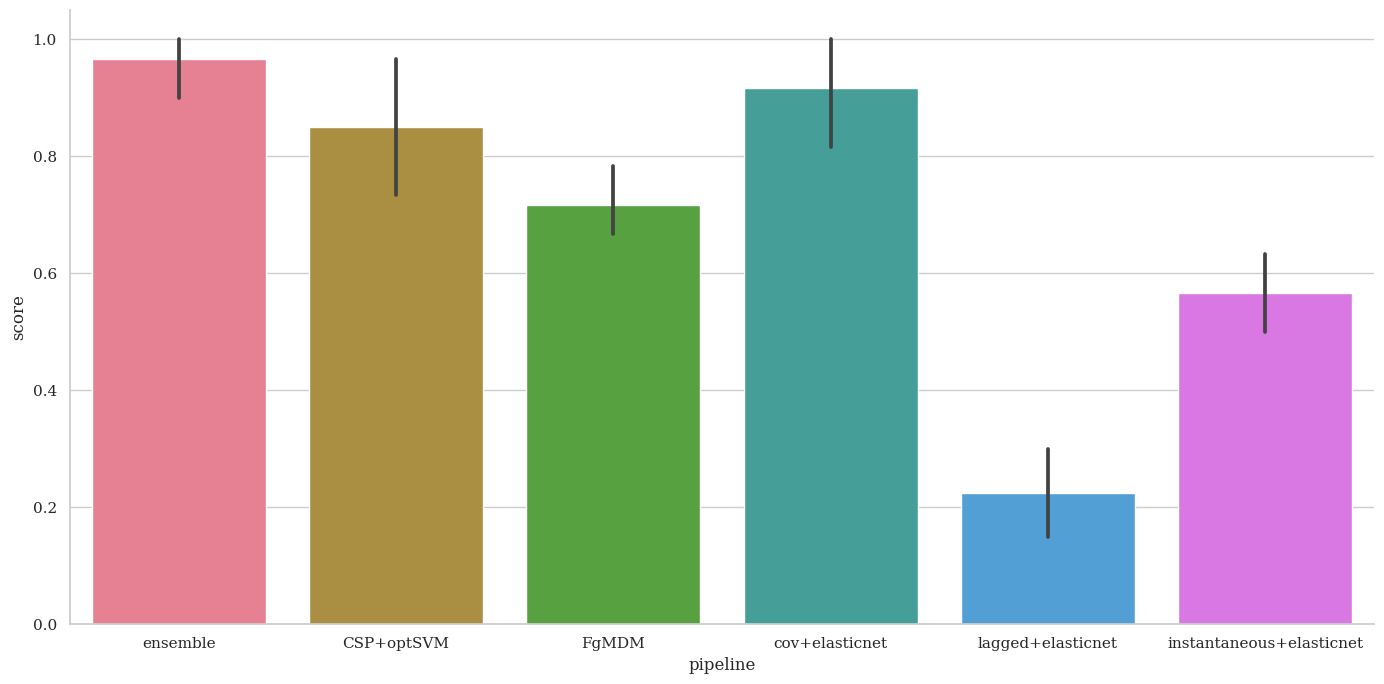

In [32]:
# plot results
list_fc_ens = ["ensemble", "CSP+optSVM", "FgMDM"] + \
    [sm + "+elasticnet" for sm in spectral_met]

g = sns.catplot(
    data=results,
    x="pipeline",
    y="score",
    kind="bar",
    order=list_fc_ens,
    height=7,
    aspect=2,
)
plt.show()